In [9]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

In [10]:
# Import data from csv file -
# (Rocketbank's anonymized transactional dataset published as part of a Data Science competition)

path_to_file = 'test.csv'
source_df = pd.read_csv(path_to_file, engine='python')

source_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,NaN,810,08APR17:00:00:00,130.00,POS


Column designations:  
period - month of the transaction;  
cl_id - client id;  
MCC - seller category code;  
channel_type - customer acquisition channel;  
currency - currency;  
TRDATETIME - date / time of the transaction;  
amount - the amount of the transaction;  
trx_category - type of transaction;  
target_flag - whether the customer will continue to use the product after the grace period (1/0) (target);  
target_sum - the sum of POS transactions for three future months (target).

In [11]:
# Grouping transactions by client ID, we get the average value of the transaction size for each client
def mean_amount_by_clients(df):
    df_clients = df.groupby('cl_id', as_index=False).agg({"amount": "mean"})
   # Sort in descending order
    df_clients = df_clients.sort_values('amount', ascending=False)

    return df_clients

df_clients = mean_amount_by_clients(source_df)
df_clients.head(5)

,cl_id,amount
2219,4374,562456.498846
726,1453,388148.145517
1140,2214,303726.857143
4003,7772,292726.146491
1583,3140,219534.062500


In [12]:
unique_clients = len(df_clients)
amount_total = df_clients['amount'].sum()


print(f'Number of clients: {unique_clients}')
print(f'Total volume of transactions for the entire period: {int(amount_total)}')

Number of clients: 5217
Total volume of transactions for the entire period: 55454481


Text(0, 0.5, 'Average transaction')

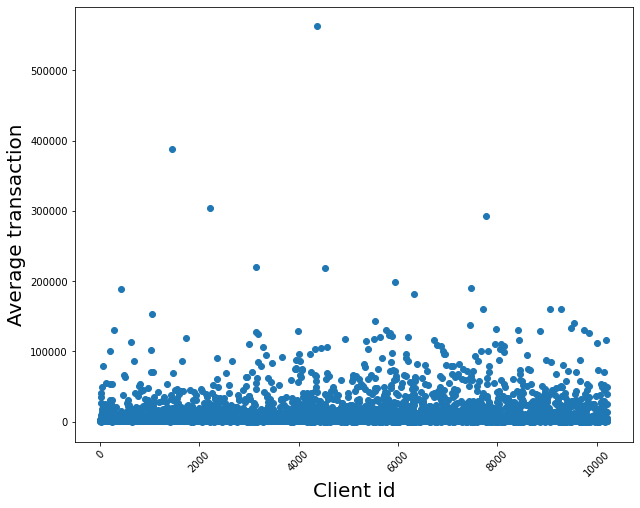

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 8))

plt.scatter(df_clients['cl_id'],df_clients['amount'])

plt.xticks(rotation=45)

plt.xlabel(u'Client id', fontsize = 20)
plt.ylabel(u'Average transaction', fontsize = 20)


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='amount'>

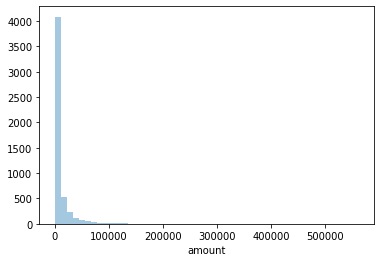

In [14]:
sns.distplot(df_clients['amount'], kde=False)

In [15]:
# Calculation of sample mean, variance, standard deviation, median
mean = df_clients['amount'].mean()
var = df_clients['amount'].var()
std = df_clients['amount'].std()
median = df_clients['amount'].median()

# Calculate a truncated mean, truncated by 10% of the highest and lowest values
trimmed_mean = scipy.stats.trim_mean(df_clients['amount'], proportiontocut=0.1)

#median absolute deviation
def mad(df):
    # parameter for lognormal distribution
    sigma = 1.2
    k = scipy.stats.lognorm.ppf(3/4., s=sigma)
    median = df.median()
    
    return k * np.median(np.fabs(df - median))


# Calculation of the MAD-characteristic (Median Absolute Deviation)
mad_value = mad(df_clients['amount'])

print(f'Average Transaction Size: Average = {int(mean)}, variance = {int(var)}, standard deviation = {int(std)},\n'
      f'median = {int(median)}, truncated mean {int(trimmed_mean)}, MAD = {int(mad_value)}')

Average Transaction Size: Average = 10629, variance = 471620310, standard deviation = 21716,
median = 3897, truncated mean 5937, MAD = 5327


In [16]:
# Calculation of the 95% confidence interval for the sample mean
norm_q95 = scipy.stats.norm.ppf(0.95)
mean_conf = norm_q95 * std / np.sqrt(len(df_clients))

# Calculation of 95% confidence intervals for variance and standard deviation
chi2_q95_left = scipy.stats.chi2.ppf((1 - 0.05 / 2.0), df=len(df_clients) - 1)
chi2_q95_right = scipy.stats.chi2.ppf(0.05 / 2.0, df=len(df_clients) - 1)

var_conf_left = var * (len(df_clients) - 1) / chi2_q95_left
var_conf_right = var * (len(df_clients) - 1) / chi2_q95_right
std_conf_left = np.sqrt(var_conf_left)
std_conf_right = np.sqrt(var_conf_right)


print("Sample mean: %0.3f +/- %0.3f" % (mean, mean_conf))
print("95%% Confidence interval of sample variance : (%0.3f; %0.3f)"
      % (var_conf_left, var_conf_right))
print("95%% Confidence interval of sample standard deviation: (%0.3f; %0.3f)"
      % (std_conf_left, std_conf_right))

Sample mean: 10629.573 +/- 494.553
95% Confidence interval of sample variance : (454030738.716; 490257245.715)
95% Confidence interval of sample standard deviation: (21307.997; 22141.753)


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


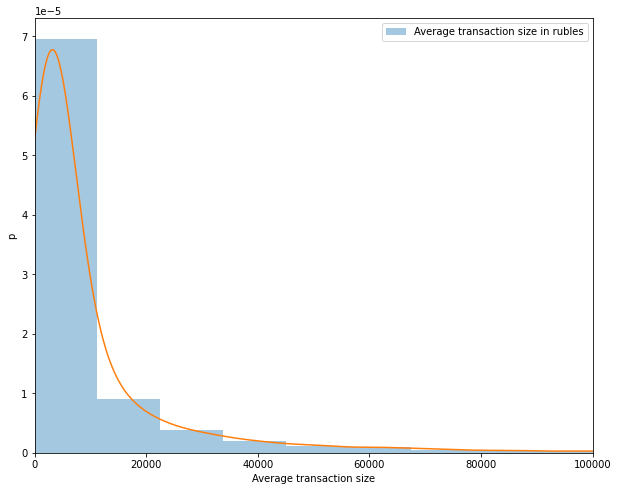

In [17]:
#Plotting a histogram and kernel density estimate
plt.figure(figsize=(10, 8))

kernel = scipy.stats.gaussian_kde(df_clients['amount'])

min_amount, max_amount = df_clients['amount'].min(), df_clients['amount'].max()
x = np.linspace(min_amount, max_amount, len(df_clients))
kde_values = kernel(x)

sns.distplot(df_clients['amount'], kde=False, norm_hist=True, label=f'Average transaction size in rubles')
plt.plot(x, kde_values)

plt.ylabel('p')
plt.xlabel('Average transaction size')
# Display values along the abscissa axis only in the interval [0, 10000]
plt.xlim(0, 10e4)
plt.legend()
plt.show()